<a href="https://colab.research.google.com/github/adityagoel715/portfolio_analyzer/blob/main/analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1. Set up and Dependencies

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


In [ ]:
portfolio_information={
    'Ticker': ['AAPL', 'MSFT', 'VTI', 'BND'],
    'Shares': [10.0, 5.5, 20.0, 50.0],
    'Cost_Per_Share': [150.50, 290.75, 95.20, 80.00],
    'Purchase_Date': ['2023-01-15', '2022-06-20', '2021-11-01', '2024-03-10'],
    'Sector': ['Technology', 'Technology', 'Index Fund', 'Bond Fund']
}

portfolio_df= pd.DataFrame(portfolio_information)

portfolio_df['Purchase_Date']=pd.to_datetime(portfolio_df['Purchase_Date'])
portfolio_df['Initial_Cost']=portfolio_df['Shares']*portfolio_df['Cost_Per_Share']

print(portfolio_df.head())

  Ticker  Shares  Cost_Per_Share Purchase_Date      Sector  Initial_Cost
0   AAPL    10.0          150.50    2023-01-15  Technology      1505.000
1   MSFT     5.5          290.75    2022-06-20  Technology      1599.125
2    VTI    20.0           95.20    2021-11-01  Index Fund      1904.000
3    BND    50.0           80.00    2024-03-10   Bond Fund      4000.000


In [ ]:
#2. Data Manager(Getting real time prices)

ticker_list=portfolio_df['Ticker'].tolist()

def find_current_prices(tickers):
  data= yf.download(tickers=tickers,period='1d')
  result = data.xs('Close', axis=1, level=0).iloc[-1]#getting most recent price
  return result

current_prices=find_current_prices(ticker_list)
current_prices.name='Current_Price'

portfolio_df=portfolio_df.set_index('Ticker')
portfolio_df=portfolio_df.join(current_prices)



/tmp/ipython-input-2172282633.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data= yf.download(tickers=tickers,period='1d')
[*********************100%***********************]  4 of 4 completed


In [ ]:
#3.Financial Analysis

portfolio_df['Market_Value']=portfolio_df['Shares']*portfolio_df['Current_Price']
portfolio_df['Dollar_change']=portfolio_df['Market_Value']-portfolio_df['Initial_Cost']
portfolio_df['Percentage_Return']=portfolio_df['Dollar_change']/portfolio_df['Initial_Cost']

portfolio_df['Weights']=portfolio_df['Market_Value']/portfolio_df['Market_Value'].sum()
portfolio_df=portfolio_df.reset_index()

In [ ]:
#4. Advanced risk metrics

In [ ]:
#Volatility

ticker_list=portfolio_df['Ticker'].tolist()
def get_historical_data(ticker):
  data = yf.download(tickers=ticker, period='1y', progress=False)
  return data['Close']
historical_data=get_historical_data(ticker_list)
# Calculate DAILY RETURNS (percentage change) for all historical data
daily_returns=historical_data.pct_change().dropna()

#Annualized volatility
annualized_volatility=daily_returns.std()*(252**0.5)
annualized_return=(daily_returns.mean()+1)**252 -1
portfolio_df = portfolio_df.merge(
    annualized_volatility.rename('Annualized_Volatility'),
    left_on='Ticker',
    right_index=True
)
portfolio_df = portfolio_df.merge(
    annualized_return.rename('Annualized_Return'),
    left_on='Ticker',
    right_index=True
)
#Sharpe Ratio
risk_free_rate=0.04
portfolio_df['Sharpe_Ratio']=(
 (portfolio_df['Annualized_Return']-risk_free_rate)/portfolio_df['Annualized_Volatility']
)

/tmp/ipython-input-620609517.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=ticker, period='1y', progress=False)



--- Correlation Matrix (Diversification) ---
Ticker  AAPL   BND  MSFT   VTI
Ticker                        
AAPL    1.00  0.10  0.52  0.74
BND     0.10  1.00 -0.02  0.10
MSFT    0.52 -0.02  1.00  0.71
VTI     0.74  0.10  0.71  1.00


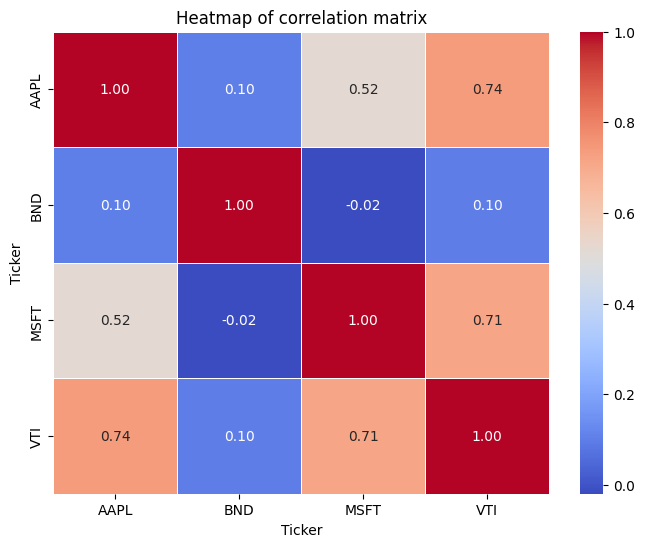

In [ ]:
#correlation_mattrix
correlation_matrix=daily_returns.corr()
print("\n--- Correlation Matrix (Diversification) ---")
print(correlation_matrix.round(2))

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix,
            annot=True,     # Show the numerical value in each cell
            cmap='coolwarm', # Colormap to use (e.g., 'viridis', 'YlGnBu', 'coolwarm')
            fmt=".2f",      # String formatting for the annotations
            linewidths=.5,  # Add lines between cells
            cbar=True       # Show the color bar (default is True)
           )
plt.title("Heatmap of correlation matrix")
plt.show()

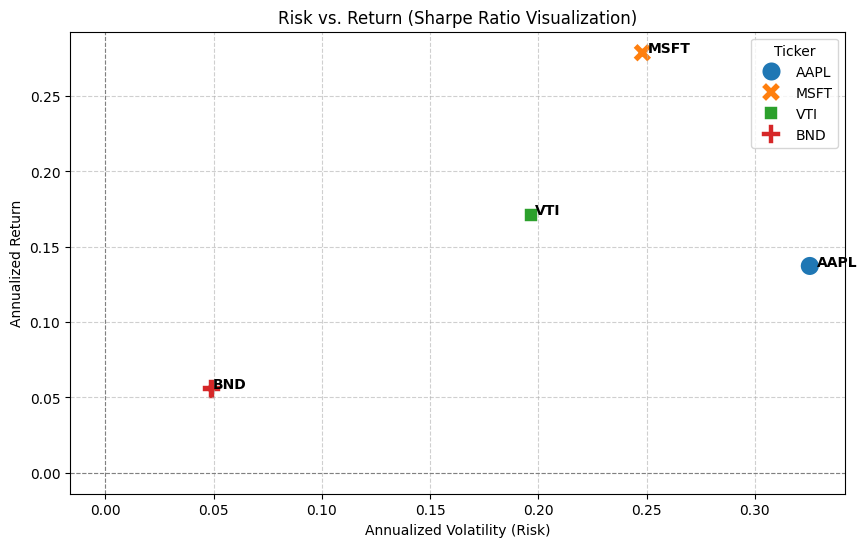

In [ ]:
#Risk-Adjusted Return Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Annualized_Volatility',
    y='Annualized_Return',
    data=portfolio_df,
    hue='Ticker',
    s=200,
    style='Ticker'
)

for line in range(0, portfolio_df.shape[0]):
     plt.text(
         portfolio_df['Annualized_Volatility'][line] * 1.01,
         portfolio_df['Annualized_Return'][line],
         portfolio_df['Ticker'][line],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold'
     )


plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Annualized Return")
plt.title("Risk vs. Return (Sharpe Ratio Visualization)")
plt.grid(True, linestyle='--', alpha=0.6)

plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

plt.show()

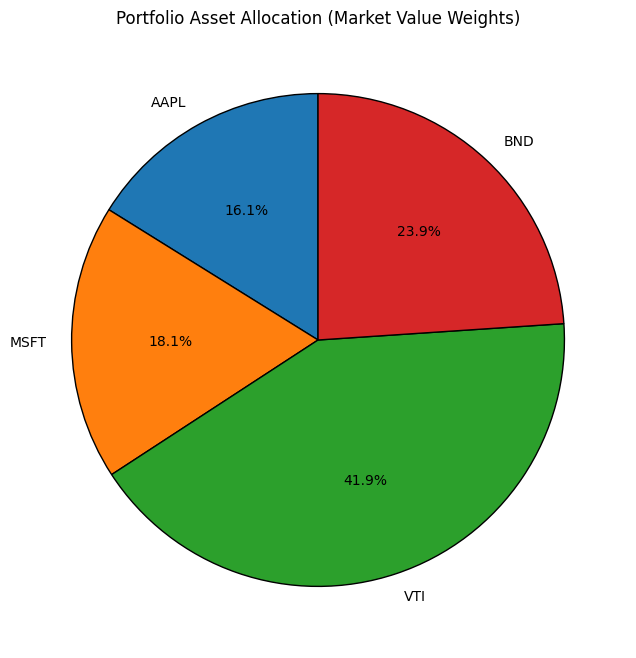

In [ ]:
# Portfolio Weight distribution
plt.figure(figsize=(8, 8))
plt.pie(
    portfolio_df['Market_Value'],
    labels=portfolio_df['Ticker'],
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)

plt.title("Portfolio Asset Allocation (Market Value Weights)")
plt.show()

In [ ]:
#Final Report
def format_portfolio_report(df):
    # Dictionary to map column names to their display formats
    formatting_dict = {
        'Shares': '{:,.2f}'.format,               # Number with 2 decimal places
        'Current_Price': '${:,.2f}'.format,      # Currency
        'Initial_Cost': '${:,.2f}'.format,       # Currency
        'Market_Value': '${:,.2f}'.format,       # Currency
        'Dollar_change': '${:,.2f}'.format,      # Currency
        'Percentage_Return': '{:.2%}'.format,    # Percentage with 2 decimal places
        'Weights': '{:.2%}'.format,              # Percentage with 2 decimal places
        'Annualized_Volatility': '{:.2%}'.format, # Percentage with 2 decimal places
        'Annualized_Return': '{:.2%}'.format,     # Percentage with 2 decimal places
        'Sharpe_Ratio': '{:,.2f}'.format         # Number with 2 decimal places
    }


    styled_df = df.style.format(formatting_dict)

    return styled_df


final_report = format_portfolio_report(portfolio_df)

print("\n\n--- FINAL PORTFOLIO PERFORMANCE REPORT ---")
# Display the styled DataFrame
from IPython.display import display
display(final_report)



--- FINAL PORTFOLIO PERFORMANCE REPORT ---


,Ticker,Shares,Cost_Per_Share,Purchase_Date,Sector,Initial_Cost,Current_Price,Market_Value,Dollar_change,Percentage_Return,Weights,Annualized_Volatility,Annualized_Return,Sharpe_Ratio
0,AAPL,10.00,150.500000,2023-01-15 00:00:00,Technology,"$1,505.00",$252.29,"$2,522.90","$1,017.90",67.63%,16.13%,32.54%,13.73%,0.30
1,MSFT,5.50,290.750000,2022-06-20 00:00:00,Technology,"$1,599.12",$513.58,"$2,824.69","$1,225.57",76.64%,18.06%,24.81%,27.88%,0.96
2,VTI,20.00,95.200000,2021-11-01 00:00:00,Index Fund,"$1,904.00",$327.30,"$6,546.00","$4,642.00",243.80%,41.86%,19.65%,17.12%,0.67
3,BND,50.00,80.000000,2024-03-10 00:00:00,Bond Fund,"$4,000.00",$74.88,"$3,744.00",$-256.00,-6.40%,23.94%,4.90%,5.57%,0.32
